In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_directory = '/content/drive/MyDrive/HARDATA_SHREYA'

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [3]:
img_size = (299, 299)  # InceptionV3 expects 299x299 images
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_directory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 3162 images belonging to 21 classes.
Found 783 images belonging to 21 classes.


In [4]:
# Load EfficientNet model from TensorFlow Hub
efficientnet_model = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
feature_extractor_layer = hub.KerasLayer(efficientnet_model, input_shape=(299, 299, 3), trainable=False)

# Build the model
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.BatchNormalization(),
    #layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(21, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [5]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

num_train_samples = train_generator.samples
num_val_samples = validation_generator.samples

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=num_val_samples // batch_size,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 3.7030 - accuracy: 0.0875 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 1895s 19s/step - loss: 3.7030 - accuracy: 0.0875 - val_loss: 2.6584 - val_accuracy: 0.3607
Epoch 2/50
98/98 [==============================] - 90s 918ms/step - loss: 2.8637 - accuracy: 0.1952 - val_loss: 2.2107 - val_accuracy: 0.4961
Epoch 3/50
98/98 [==============================] - 94s 959ms/step - loss: 2.5053 - accuracy: 0.2799 - val_loss: 1.7942 - val_accuracy: 0.5443
Epoch 4/50
98/98 [==============================] - 89s 913ms/step - loss: 2.2225 - accuracy: 0.3371 - val_loss: 1.5227 - val_accuracy: 0.5898
Epoch 5/50
98/98 [==============================] - 90s 921ms/step - loss: 2.0393 - accuracy: 0.3853 - val_loss: 1.3677 - val_accuracy: 0.6094
Epoch 6/50
98/98 [==============================] - 89s 910ms/step - loss: 1.9634 - accuracy: 0.4141 - val_loss: 1.2531 - val_accuracy: 0.6380
Epoch 7/50
98/98 [==============================] - 89s 906ms/step - loss: 1.8099 - accuracy: 0.4457 - val_loss: 1.1831 - val_accuracy: 0.6432
Epoch 8/50

In [6]:
# Load the best model
model.load_weights('best_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

25/25 [==============================] - 7s 289ms/step - loss: 0.8112 - accuracy: 0.7420
Validation Loss: 0.8112094402313232
Validation Accuracy: 0.7420178651809692


In [7]:
model.save('efficientnet_human_activity_model.h5')

Found 783 images belonging to 21 classes.
25/25 [==============================] - 6s 201ms/step


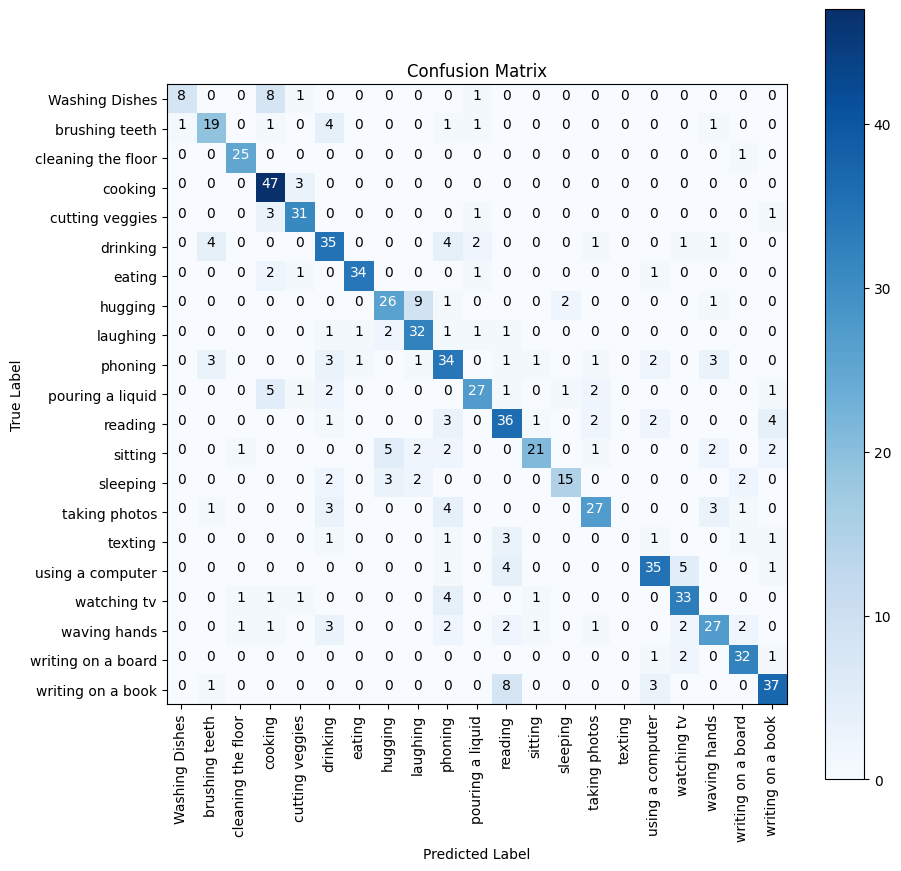

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure validation generator does not shuffle the data
validation_generator = validation_datagen.flow_from_directory(
    dataset_directory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Get predictions
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding values in the plot
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f"{conf_matrix[i, j]}", horizontalalignment="center",
             color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()
